In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Nicky van Foreest(vanforeest@gmail.com)                        #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################
#######################################################################
# Copyright (C)                                                       #
# 2017 Cheung Auyeung(cheung.auyeung@gmail.com)                       #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Actions: hit or stick

The actions of the player and the dealer are to hit or to stick. 

In [3]:
ACTION_HIT = 0    #  request additional cards
ACTION_STICK = 1  #  stop the game
actions = [ACTION_HIT, ACTION_STICK]

## Target policy of player

Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.

In [4]:
policyPlayer = np.zeros(22)
for i in range(12, 20):
    policyPlayer[i] = ACTION_HIT
policyPlayer[20] = ACTION_STICK
policyPlayer[21] = ACTION_STICK

# function form of target policy of player
def targetPolicyPlayer(usableAcePlayer, playerSum, dealerCard):
    return policyPlayer[playerSum]

##  Behavior policy of player

In [5]:

def behaviorPolicyPlayer(usableAcePlayer, playerSum, dealerCard):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STICK
    return ACTION_HIT

## Policy for dealer

The dealer hits or sticks according to a fixed strategy without choice:
he sticks on any sum of 17 or greater, and hits otherwise.

In [6]:
policyDealer = np.zeros(22)
for i in range(12, 17):
    policyDealer[i] = ACTION_HIT
for i in range(17, 22):
    policyDealer[i] = ACTION_STICK

## Play a game

The player makes decisions on the basis
of three variables: his current sum (12-21), the dealer’s one showing card (ace-10),
and whether or not he holds a usable ace. This makes for a total of 200 states. And a player state is given by
```Python
    state = (usableAcePlayer, playerSum, dealerCard1)
```

In [7]:
def getCard():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

In [8]:
# generate a random initial state for the player
def playerSetup() :
    # sum of player
    playerSum = 0

    # whether player uses Ace as 11
    usableAcePlayer = False
    numOfAce = 0

    # initialize cards of player
    while playerSum < 12:
        # if sum of player is less than 12, always hit
        card = getCard()

        # if get an Ace, use it as 11
        if card == 1:
            numOfAce += 1
            card = 11
            usableAcePlayer = True
            
        playerSum += card

    # Since the playerSum before the last card is less than 12,
    # if the player's sum is larger than 21 after the last card, 
    # the last card must be an Ace.
    # Two Aces are possible.
    if playerSum > 21:
        # use the Ace as 1 rather than 11
        playerSum -= 10

        # if the player only has one Ace, then he doesn't have 
        # usable Ace any more
        if numOfAce == 1:
            usableAcePlayer = False
            
    # playerSum is between 12 and 21 inclusive            
    return playerSum, usableAcePlayer

In [9]:
# player's turn
def playerTurn(policyPlayerFn, initialAction, state):
    usableAcePlayer, playerSum, dealerCard1 = state
    
    # trajectory of player
    playerTrajectory = []
    while True:
        if initialAction is not None:
            action = initialAction
            initialAction = None
        else:
            # get action based on current sum
            action = policyPlayerFn(usableAcePlayer, playerSum, dealerCard1)

        # track player's trajectory for importance sampling
        state = (usableAcePlayer, playerSum, dealerCard1)
        playerTrajectory.append([action, state])

        if action == ACTION_STICK:
            return playerSum, playerTrajectory
        
        # if hit, get new card
        playerSum += getCard()

        # player busts
        if playerSum > 21:
            # if player has a usable Ace, use it as 1 to avoid busting and continue
            if usableAcePlayer == True:
                playerSum -= 10
                usableAcePlayer = False
            else:
                return playerSum, playerTrajectory

In [10]:
# dealer's turn
def dealerTurn(dealerCard1, dealerCard2) :
    # initialize dealer's sum
    dealerSum = 0
    usableAceDealer = False
    if dealerCard1 == 1 and dealerCard2 != 1:
        dealerSum += 11 + dealerCard2
        usableAceDealer = True
    elif dealerCard1 != 1 and dealerCard2 == 1:
        dealerSum += dealerCard1 + 11
        usableAceDealer = True
    elif dealerCard1 == 1 and dealerCard2 == 1:
        dealerSum += 1 + 11
        usableAceDealer = True
    else:
        dealerSum += dealerCard1 + dealerCard2

    while True:
        # get action based on current sum
        action = policyDealer[dealerSum]
        if action == ACTION_STICK:
            return dealerSum
        
        # if hit, get a new card
        dealerSum += getCard()

        # dealer busts
        if dealerSum > 21:
            if usableAceDealer == True:
            # if dealer has a usable Ace, use it as 1 to avoid busting and continue
                dealerSum -= 10
                usableAceDealer = False
            else:
                return dealerSum
            


In [11]:
# @policyPlayerFn: specify policy for player
# @initialState: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# @initialAction: the initial action
def play(policyPlayerFn, initialState=None, initialAction=None):
    if initialState is None:
        # dealer get two cards, suppose dealer will 
        # show the first card he gets
        dealerCard1 = getCard()
        dealerCard2 = getCard()
        
        # The player get two or more cards until the sum is at least 12
        playerSum, usableAcePlayer = playerSetup()
    else:
        # use specified initial state
        dealerCard1 = initialState[2]
        dealerCard2 = getCard()
        usableAcePlayer = initialState[0]
        playerSum = initialState[1]


    # initial state of the game
    state = (usableAcePlayer, playerSum, dealerCard1)

    # game starts!
    playerSum, playerTrajectory = \
        playerTurn(policyPlayerFn, initialAction, state)
    if (playerSum>21) :
        return state, -1, playerTrajectory

    dealerSum = dealerTurn(dealerCard1, dealerCard2)
    if (dealerSum>21) :
        return state, 1, playerTrajectory
            
    # compare the sum between player and dealer
    if playerSum > dealerSum:
        return state, 1, playerTrajectory
    elif playerSum == dealerSum:
        return state, 0, playerTrajectory
    else:
        return state, -1, playerTrajectory

Estimate the state value using Monte Carlo (MC )Prediction. However the method used is neither first-vistit nor every-visit MC.

In [12]:
# Monte Carlo Sample with On-Policy
def monteCarloOnPolicy(nEpisodes):
    statesUsableAce = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    statesUsableAceCount = np.ones((10, 10))
    statesNoUsableAce = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    statesNoUsableAceCount = np.ones((10, 10))
    for i in range(0, nEpisodes):
        state, reward, _ = play(targetPolicyPlayer)
        usableAcePlayer, playerSum, dealerCard1 = state
        playerSum -= 12
        dealerCard1 -= 1
        if usableAcePlayer:
            statesUsableAceCount[playerSum, dealerCard1] += 1
            statesUsableAce[playerSum, dealerCard1] += reward
        else:
            statesNoUsableAceCount[playerSum, dealerCard1] += 1
            statesNoUsableAce[playerSum, dealerCard1] += reward
    return statesUsableAce / statesUsableAceCount, \
            statesNoUsableAce / statesNoUsableAceCount

In [13]:
# print the state value
figureIndex = 0
def prettyPrint(data, tile, zlabel='reward', elev=25, azim=-135):
    global figureIndex
    figureIndex += 1
    fig = plt.figure(figureIndex, figsize=(12, 6))
    fig.suptitle(tile)
    
    ax = fig.add_subplot(121)
    im = ax.matshow(data,cmap="jet",origin='lower', \
                    extent=[0.5,10.5, 11.5, 21.5])
    fig.colorbar(im,fraction=0.046, pad=0.04)
    ax.set_ylabel('player sum')
    ax.set_xlabel('dealer showing')   
    
    ax = fig.add_subplot(122, projection='3d')
    ax.view_init(elev, azim)
    axisX = []
    axisY = []
    axisZ = []
    for i in range(12, 22):
        for j in range(1, 11):
            axisX.append(i)
            axisY.append(j)
            axisZ.append(data[i - 12, j - 1])           
    ax.scatter(axisX, axisY, axisZ)
    ax.set_xlabel('player sum')
    ax.set_ylabel('dealer showing')
    ax.set_zlabel(zlabel)

In [14]:
# Figure 5.1
def onPolicy(elev=25, azim=45):
    statesUsableAce1, statesNoUsableAce1 = monteCarloOnPolicy(10000)
    statesUsableAce2, statesNoUsableAce2 = monteCarloOnPolicy(500000)
    prettyPrint(statesUsableAce1, 'Usable Ace, 10000 Episodes', 
                elev=elev, azim=azim)
    prettyPrint(statesNoUsableAce1, 'No Usable Ace, 10000 Episodes', 
                elev=elev, azim=azim)
    prettyPrint(statesUsableAce2, 'Usable Ace, 500000 Episodes', 
                elev=elev, azim=azim)
    prettyPrint(statesNoUsableAce2, 'No Usable Ace, 500000 Episodes', 
                elev=elev, azim=azim)
    plt.show()

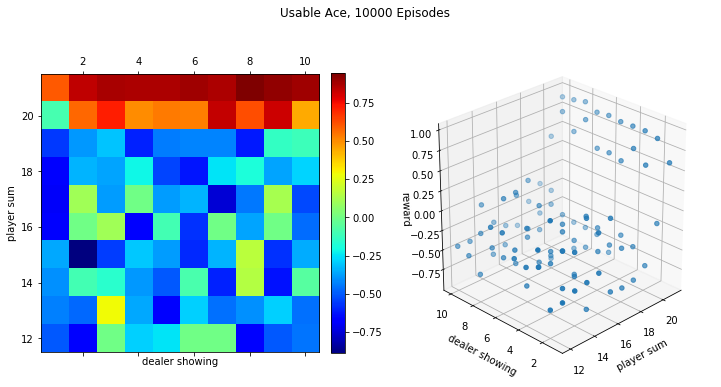

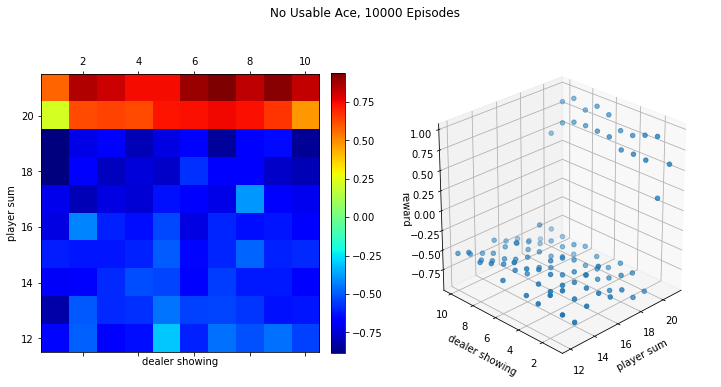

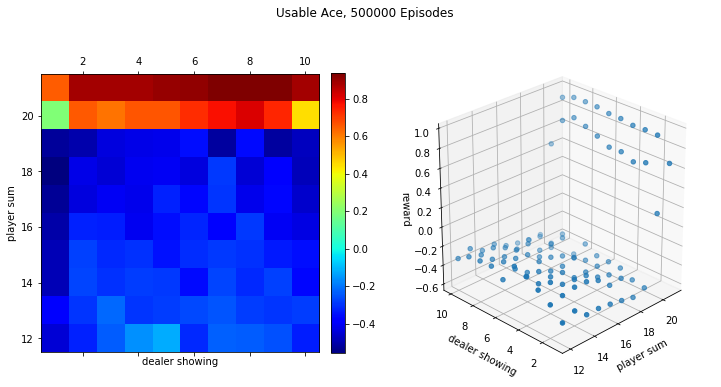

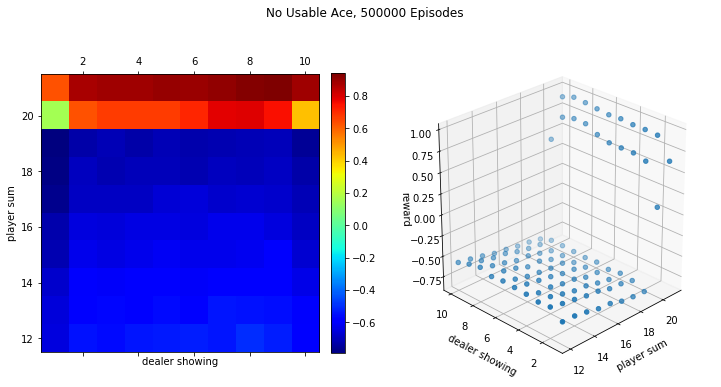

In [15]:
onPolicy(elev=25, azim=-135)

In [16]:
# Monte Carlo with Exploring Starts
def monteCarloES(nEpisodes):
    # (playerSum, dealerCard, usableAce, action)
    stateActionValues = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    stateActionPairCount = np.ones((10, 10, 2, 2))

    # behavior policy is greedy
    def behaviorPolicy(usableAce, playerSum, dealerCard):
        usableAce = int(usableAce)
        playerSum -= 12
        dealerCard -= 1
        # get argmax of the average returns(s, a)
        return np.argmax(stateActionValues[playerSum, dealerCard, usableAce, :]
                    / stateActionPairCount[playerSum, dealerCard, usableAce, :])

    # play for several episodes
    for episode in range(nEpisodes):
        if episode % 10000 == 0:
            print('episode:', episode)
        # for each episode, use a randomly initialized state and action
        initialState = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initialAction = np.random.choice(actions)
        _, reward, trajectory = play(behaviorPolicy, initialState, initialAction)
        for action, (usableAce, playerSum, dealerCard) in trajectory:
            usableAce = int(usableAce)
            playerSum -= 12
            dealerCard -= 1
            # update values of state-action pairs
            stateActionValues[playerSum, dealerCard, usableAce, action] += reward
            stateActionPairCount[playerSum, dealerCard, usableAce, action] += 1

    return stateActionValues / stateActionPairCount

In [17]:
# Figure 5.3
def figure5_3():
    stateActionValues = monteCarloES(500000)
    stateValueUsableAce = np.zeros((10, 10))
    stateValueNoUsableAce = np.zeros((10, 10))
    # get the optimal policy
    actionUsableAce = np.zeros((10, 10), dtype='int')
    actionNoUsableAce = np.zeros((10, 10), dtype='int')
    for i in range(10):
        for j in range(10):
            stateValueNoUsableAce[i, j] = np.max(stateActionValues[i, j, 0, :])
            stateValueUsableAce[i, j] = np.max(stateActionValues[i, j, 1, :])
            actionNoUsableAce[i, j] = np.argmax(stateActionValues[i, j, 0, :])
            actionUsableAce[i, j] = np.argmax(stateActionValues[i, j, 1, :])
            
    prettyPrint(actionUsableAce, 'Optimal policy with usable Ace', \
                'Action (0 Hit, 1 Stick)')
    prettyPrint(actionNoUsableAce, 'Optimal policy with no usable Ace', \
                'Action (0 Hit, 1 Stick)')

    prettyPrint(stateValueUsableAce, 'Optimal state value with usable Ace')
    prettyPrint(stateValueNoUsableAce, 'Optimal state value with no usable Ace')
    plt.show()

episode: 0
episode: 10000
episode: 20000
episode: 30000
episode: 40000
episode: 50000
episode: 60000
episode: 70000
episode: 80000
episode: 90000
episode: 100000
episode: 110000
episode: 120000
episode: 130000
episode: 140000
episode: 150000
episode: 160000
episode: 170000
episode: 180000
episode: 190000
episode: 200000
episode: 210000
episode: 220000
episode: 230000
episode: 240000
episode: 250000
episode: 260000
episode: 270000
episode: 280000
episode: 290000
episode: 300000
episode: 310000
episode: 320000
episode: 330000
episode: 340000
episode: 350000
episode: 360000
episode: 370000
episode: 380000
episode: 390000
episode: 400000
episode: 410000
episode: 420000
episode: 430000
episode: 440000
episode: 450000
episode: 460000
episode: 470000
episode: 480000
episode: 490000


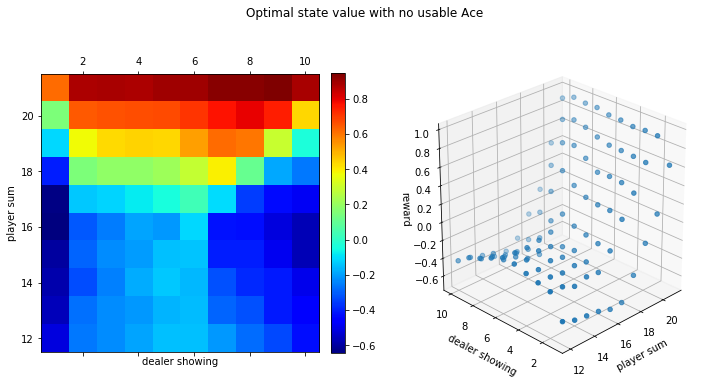

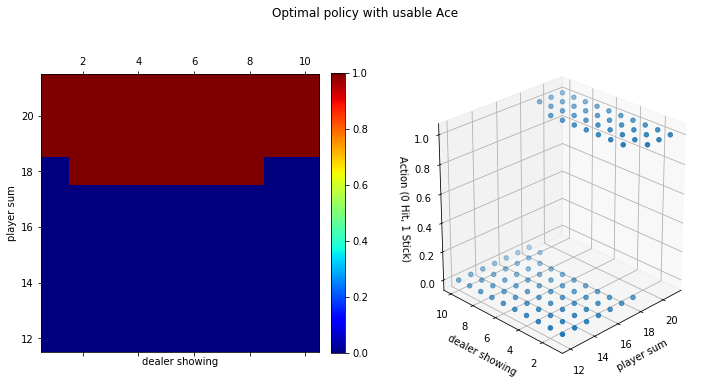

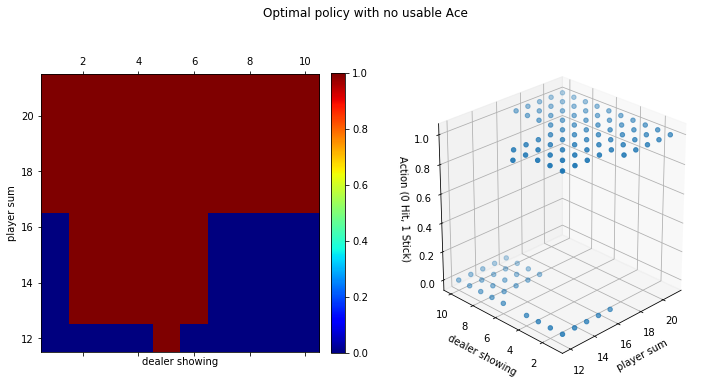

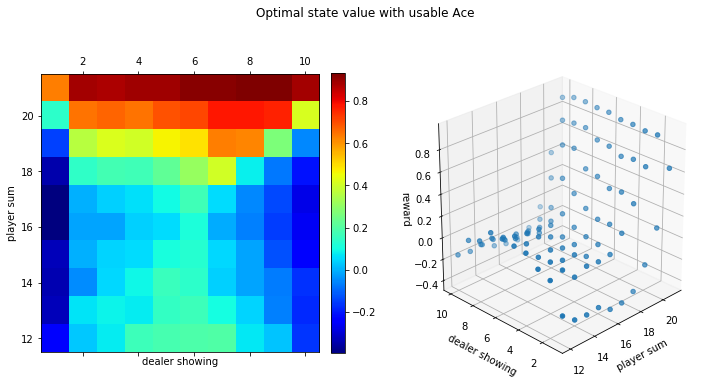

In [18]:
np.random.seed(seed=42)
figure5_3()

In [19]:
# Monte Carlo Sample with Off-Policy
def monteCarloOffPolicy(nEpisodes):
    initialState = [True, 13, 2]
    sumOfImportanceRatio = [0]
    sumOfRewards = [0]
    for i in range(0, nEpisodes):
        _, reward, playerTrajectory = play(behaviorPolicyPlayer, initialState=initialState)

        # get the importance ratio
        importanceRatioAbove = 1.0
        importanceRatioBelow = 1.0
        for action, (usableAce, playerSum, dealerCard) in playerTrajectory:
            if action == targetPolicyPlayer(usableAce, playerSum, dealerCard):
                importanceRatioBelow *= 0.5
            else:
                importanceRatioAbove = 0.0
                break
        importanceRatio = importanceRatioAbove / importanceRatioBelow
        sumOfImportanceRatio.append(sumOfImportanceRatio[-1] + importanceRatio)
        sumOfRewards.append(sumOfRewards[-1] + reward * importanceRatio)
    del sumOfImportanceRatio[0]
    del sumOfRewards[0]

    sumOfRewards= np.asarray(sumOfRewards)
    sumOfImportanceRatio= np.asarray(sumOfImportanceRatio)
    ordinarySampling = sumOfRewards / np.arange(1, nEpisodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weightedSampling = np.where(sumOfImportanceRatio != 0, \
                                    sumOfRewards / sumOfImportanceRatio, 0)

    return ordinarySampling, weightedSampling

In [20]:
# Figure 5.4
def offPolicy():
    trueValue = -0.27726
    nEpisodes = 10000
    nRuns = 100
    ordinarySampling = np.zeros(nEpisodes)
    weightedSampling = np.zeros(nEpisodes)
    for i in range(0, nRuns):
        ordinarySampling_, weightedSampling_ = monteCarloOffPolicy(nEpisodes)
        # get the squared error
        ordinarySampling += np.power(ordinarySampling_ - trueValue, 2)
        weightedSampling += np.power(weightedSampling_ - trueValue, 2)
    ordinarySampling /= nRuns
    weightedSampling /= nRuns
    axisX = np.log10(np.arange(1, nEpisodes + 1))
    plt.plot(axisX, ordinarySampling, label='Ordinary Importance Sampling')
    plt.plot(axisX, weightedSampling, label='Weighted Importance Sampling')
    plt.xlabel('Episodes (10^x)')
    plt.ylabel('Mean square error')
    plt.legend()
    plt.show()

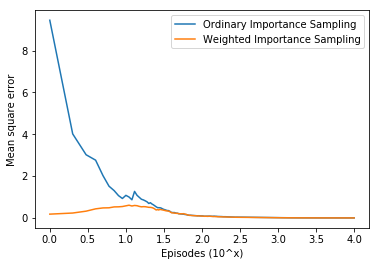

In [21]:
offPolicy()